# A3P1: So here's a number
We'll be using multilayer perceptrons to identify handwritten numbers. As usual, we'll begin by importing some libraries

In [ ]:
# imports
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# the images are stored as a couple of pickles
my_drive = 'drive/MyDrive/MSDS_422/assign-3-part-1/'
Ntrain = pd.read_pickle(os.path.join(my_drive, 'assign-3-part-1-train.pickle'))
Ntrain.shape # (40320, 786) 40,320 images, 28 x 28 pixels 
Ntrain[Ntrain.columns[0:10]].head() # lets look at the head

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8
40162,2,0,0,0,0,0,0,0,0,0
36992,1,0,0,0,0,0,0,0,0,0
39884,1,0,0,0,0,0,0,0,0,0
10946,0,0,0,0,0,0,0,0,0,0
13921,2,0,0,0,0,0,0,0,0,0


There is a label, 784 pixel values 0-255, representing a 28 x 28 pixel image and an image number (representing the source??)
<p>
Dataframe is an odd way to show this. Can we look at them like the people do?

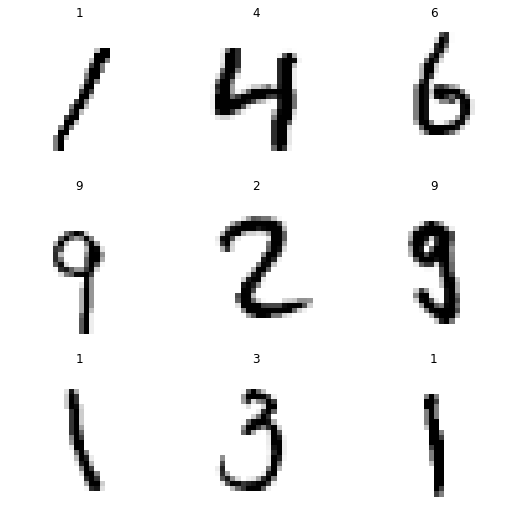

In [ ]:
fig, ax = plt.subplots(3, 3, figsize = (9,9)) # lets make a figure
for i in range(1, 10): # 9 pieces - matplotlib wants #1-9, not 0-8
  ax = plt.subplot(3, 3, i) # set subplot
  pick = Ntrain.sample(1, random_state = i) # pick a row
  label = int(pick['label']) # label = for our row
  img = pick.drop(['label', 'imageID'], axis = 1) # pixel values
  img = np.array(img) #convert pixels to array
  img = np.reshape(img, (28,28)) # reshape ot 28x28
  plt.imshow(img, cmap='gray_r') # show image - invert so pen is black
  ax.set_title(label) # title is label
  plt.axis('off')

These labels look correct. Incorrect labels are the bane of machine learning, but I don't feel like looking at all 43k at once. Perhaps machine learning can help us find them?

In [ ]:
# we'll define our training and validation data sets (test is another pickle)
from sklearn.model_selection import train_test_split
y = Ntrain['label'].to_numpy().astype(np.int32) #target as int array
X = np.array(Ntrain.drop(['label', 'imageID'], axis = 1)) #values
np.min(X) # 0 # checking values are valid for an image (0-255)
np.max(X) # 255
X = X.astype(np.float32) / 255. # rescale to 0-1, set as float
trainX, valX, trainy, valy = train_test_split(X, y, # splits
                              test_size = 0.2, random_state = 21)
trainX.shape

(32256, 784)

# building the model
we'll define a multilayer perceptron, which inputs the data, then passes it through a series of fully connected (dense) layers. Here, dense refers to the connections, not the acumen of the programmer (hopefully). We'll use rectified linear activation (if x <0: 0; else x) in between the layers. The final layer has 10 weights - 1 for each digit, and gives a softmax activation so the final result is an array of 10 values - the one with the highest weight is the models guess.

In [ ]:
import tensorflow as tf
from tensorflow import keras
# modified from Geron - our input is already flattened
model = keras.models.Sequential([ # 1-D model
  keras.layers.Input(shape = [784]), # 784 pixels
  keras.layers.Dense(300, activation = 'relu'), # 300 neurons
  keras.layers.Dense(100, activation = 'relu'), # 100 neurons
  keras.layers.Dense(10, activation = 'softmax') # 10 possible answers
], name='base_model')
model.summary()

Model: "base_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 300)               235500    
_________________________________________________________________
dense_23 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_24 (Dense)             (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# compile the model, set optimizer + metrics
model.compile(
    loss = "sparse_categorical_crossentropy", #penalize degree of wrongness
    optimizer = keras.optimizers.SGD(lr=0.01), #explicit LR - can change later
    metrics = ['accuracy'])

In [ ]:
# fit -> watch the bars go by
history = model.fit(trainX, trainy, epochs = 10, batch_size= 32,
                  validation_data = (valX,valy))

Epoch 1/10
1008/1008 [==============================] - 4s 4ms/step - loss: 1.2596 - accuracy: 0.6585 - val_loss: 0.3910 - val_accuracy: 0.8899
Epoch 2/10
1008/1008 [==============================] - 4s 4ms/step - loss: 0.3575 - accuracy: 0.9013 - val_loss: 0.3072 - val_accuracy: 0.9106
Epoch 3/10
1008/1008 [==============================] - 4s 4ms/step - loss: 0.2871 - accuracy: 0.9163 - val_loss: 0.2679 - val_accuracy: 0.9213
Epoch 4/10
1008/1008 [==============================] - 4s 4ms/step - loss: 0.2593 - accuracy: 0.9273 - val_loss: 0.2425 - val_accuracy: 0.9292
Epoch 5/10
1008/1008 [==============================] - 4s 4ms/step - loss: 0.2198 - accuracy: 0.9380 - val_loss: 0.2213 - val_accuracy: 0.9340
Epoch 6/10
1008/1008 [==============================] - 4s 4ms/step - loss: 0.1951 - accuracy: 0.9449 - val_loss: 0.2066 - val_accuracy: 0.9384
Epoch 7/10
1008/1008 [==============================] - 4s 4ms/step - loss: 0.1757 - accuracy: 0.9496 - val_loss: 0.1892 - val_accuracy:

This is very good. Given the very high accuracy can we look for mislabeled numbers?

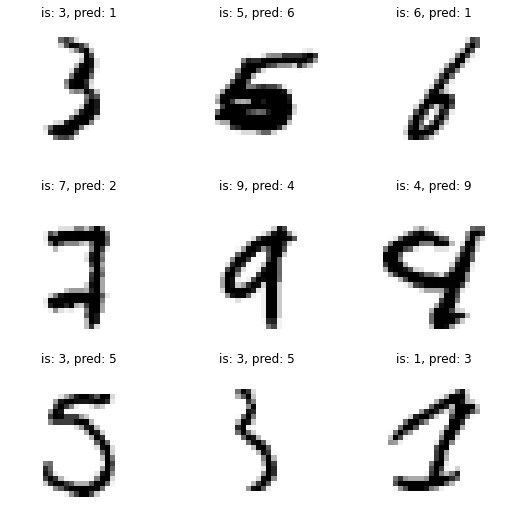

In [ ]:
preds = model.predict(trainX) # predict the numbers
preds = np.argmax(preds, axis = 1) # convert probabilites to predictions
wrong_finder = pd.DataFrame({'label':trainy, 'prediction':preds})
re_X = pd.DataFrame(trainX).add_prefix('pixel_') # re-engineer x values
re_X = (re_X * 255).astype(np.uint8)
wrong_finder = pd.concat([wrong_finder, re_X], axis = 1)
wrong_finder = wrong_finder[wrong_finder['label'] != wrong_finder['prediction']]
wrong_finder.shape #(575, 786)
fig, ax = plt.subplots(3, 3, figsize = (9,9)) # lets make a figure
for i in range(1, 10): # 9 pieces - matplotlib wants #1-9, not 0-8
  ax = plt.subplot(3, 3, i) # set subplot
  pick = wrong_finder.sample(1, random_state = i *9) # pick a row
  label = int(pick['label']) # label = for our row
  pred = int(pick['prediction']) # prediction
  img = pick.drop(['label', 'prediction'], axis = 1) # pixel values
  img = np.array(img) #convert pixels to array
  img = np.reshape(img, (28,28)) # reshape ot 28x28
  plt.imshow(img, cmap='gray_r') # show image - invert so pen is black
  ax.set_title(f'is: {label}, pred: {pred}') # title is label and guess
  plt.axis('off')

1. The model is making reasonable mistakes. We could use a confusion matrix to investigate further.
2. One number (bottom left) appears mislabeled - I agree with the model that it's a 5 and not a 3. Exhaustively weeding these out could help improve model accuracy.

# tuning hyperparameters
We're going to define and train 4 models which differ in the number of layers and neurons. 
<p> As a reminder, the baseline model is: <p>

1.   input 784 pixels
2.   fully connected, 300 neurons
3.   fully connected, 100 neurons
4. fully connected, 10 neurons, softmax

1 and 4 are invariant. We'll do:
* More layers: (300 -> 200 -> 100 -> 50 -> 10)
* Fewer layers (300 -> 10)
* Fewer neurons (100 -> 25 -> 10)
* Way fewer neurons (10 -> 5 -> 10)

We'll consider time and accuracy for these models. Changing optimizers, LR, and number of epochs are common hyperparameters. Gerons suggests removing the outer pixel as it is (almost?) always blank. Given the data, going to a simpler datatype is reasonable. float16 is very hot right now, but it looks so black and white I would consider going all the way to binary.

# defining variant models
I'll do this explicitly. I have tried more "pythonic" ways of building these models (e.g. for loops, methods, cramming it into GridSearchCV), but the space savings were not proportionate to the decrease in legibility or use of programmer time (the only truly limited resource!).
<p>
Next time, I might try keras-tuner: https://keras-team.github.io/keras-tuner/



In [ ]:
# more layers
model_more_layers = keras.models.Sequential([
  keras.layers.Input(shape = [784]),
  keras.layers.Dense(300, activation = 'relu'),
  keras.layers.Dense(200, activation = 'relu'), # added layer
  keras.layers.Dense(100, activation = 'relu'),
  keras.layers.Dense(50, activation = 'relu'), # added layer
  keras.layers.Dense(10, activation = 'softmax')
], name='more_layers')

# fewer layers
model_fewer_layers = keras.models.Sequential([ # 1-D model
  keras.layers.Input(shape = [784]), # 784 pixels
  keras.layers.Dense(300, activation = 'relu'),
  # skipped the 100 neuron layer
  keras.layers.Dense(10, activation = 'softmax') # 10 possible answers
], name='fewer_layers')

# fewer neurons
model_fewer_neurons = keras.models.Sequential([
  keras.layers.Input(shape = [784]),
  keras.layers.Dense(100, activation = 'relu'), # 300 -> 100 neurons
  keras.layers.Dense(25, activation = 'relu'), # 100 -> 25 neurons
  keras.layers.Dense(10, activation = 'softmax')
], name='fewer_neurons')

# way fewer neurons -> I'm worried about this one
model_way_fewer_neurons = keras.models.Sequential([
  keras.layers.Input(shape = [784]),
  keras.layers.Dense(10, activation = 'relu'), # 300 -> 10 neurons
  keras.layers.Dense(5, activation = 'relu'), # 100 -> 5 neurons
  keras.layers.Dense(10, activation = 'softmax')
], name='way_fewer_neurons')

# testing variants

In [ ]:
# setup - typically keras shuffles data (randomly) and layers are randomly
# initialized. Here is some code to fix that. 
# Source: https://keras.io/getting_started/faq/
import random as python_random

!PYTHONHASHSEED=0
np.random.seed(21)
python_random.seed(21)
tf.random.set_seed(21)

from timeit import default_timer as timer # timing program

variants = [model, # baseline
            model_more_layers, model_fewer_layers, #change layers
            model_fewer_neurons, model_way_fewer_neurons] # change neurons
resList=[] # for storing our results
resToPlot = [] # for making a graph
for variant in variants:
  variant.compile(
      loss = "sparse_categorical_crossentropy", #penalize degree of wrongness
      optimizer = keras.optimizers.SGD(lr=0.01), #explicit LR - can change later
      metrics = ['accuracy'])
  start = timer() # time training
  history = variant.fit(trainX, trainy, epochs = 10, batch_size= 32, 
                  verbose = 0, # no printout -> slows it down
                  validation_data = (valX,valy))
  end = timer()
  elapsed = end - start
  resList.append({'model': variant.name,
    'val_accuracy':history.history['val_accuracy'][-1],
    'train_accuracy':history.history['accuracy'][-1],
    'train_val_time':elapsed})
  resToPlot.append({'model':variant.name, 
          'val_accs':history.history['val_accuracy']})

result = pd.DataFrame(resList)
result

,model,val_accuracy,train_accuracy,train_val_time
0,base_model,0.967262,0.979942,28.286227
1,more_layers,0.964906,0.975074,33.468207
2,fewer_layers,0.937128,0.943452,24.667147
3,fewer_neurons,0.947421,0.954365,15.846925
4,way_fewer_neurons,0.891989,0.893911,11.105047


The base model (a literal "textbook answer") has the highest accuracy. Adding layers slows the model down without increasing accuracy. Removing neurons gives a significant speed boost with mild drop in accuracy. That may or may not be worth it. If a mismatch triggers manual review a drop inaccuracy from 96 to 94 percent increases the number of digits for manual review by 50% (from 4% to 6%). 

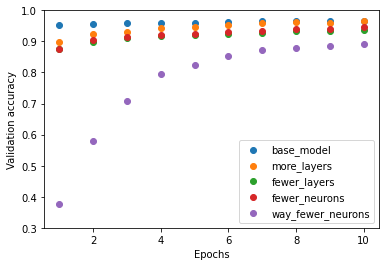

In [ ]:
labels = []
fig, ax = plt.subplots()
for result in resToPlot:
  plt.scatter(range(1,11), result['val_accs'])
  labels.append(result['model'])
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')
ax.set_ylim(0.30, 1)
plt.legend(labels=labels)

The models seem to have reached an end-state after 10 epochs, so that's sufficient. We also didn't see any big drops in accuracy or (much) drooping in the accuracy that would be concerning for overfitting.

# kaggle 
In the next step, we'll prepare the (unlabled) testing data and submit for grading by kaggle
Use whichever version of your models, above, that is your "best" (i.e., most accurate) one, to predict the labels for the data in the separate test file. Be sure to remember to apply any preprocessing transformations.
Put your label predictions in a csv file that has two columns, "imageID", and "label" The values for imageID are those that are in the test data file. The values for "label" should be integers from 0 to 9.
Instructions for uploading your predictions to Kaggle for scoring will be provided separately

In [ ]:
Ntest = pd.read_pickle(os.path.join(my_drive, 'assign-3-part-1-test.pickle'))
Ntest.shape # (40320, 786) 40,320 images, 28 x 28 pixels 
Ntest[Ntest.columns[0:10]].head() # lets look at the head

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8
38840,NaN,0,0,0,0,0,0,0,0,0
6003,NaN,0,0,0,0,0,0,0,0,0
8977,NaN,0,0,0,0,0,0,0,0,0
27361,NaN,0,0,0,0,0,0,0,0,0
16614,NaN,0,0,0,0,0,0,0,0,0


In [ ]:
testy = Ntest['label'].to_numpy().astype(np.int32) #target as int array
testX = np.array(Ntest.drop(['label', 'imageID'], axis = 1)) #values
np.min(testX) # 0 # checking values are valid for an image (0-255)
np.max(testX) # 255
testX = testX.astype(np.float32) / 255. # rescale to 0-1, set as float
print (testX.shape)
testPreds = model.predict(testX).argmax(axis = 1)
testguess = pd.DataFrame({'label':testPreds, 
                          'imageID':Ntest['imageID'].to_numpy()}, index=None)
testguess.to_csv(os.path.join(my_drive, 'test_guess.csv'))
testguess.head()

(1680, 784)


,label,imageID
0,2,31806
1,6,35802
2,4,8948
3,1,38878
4,2,16133


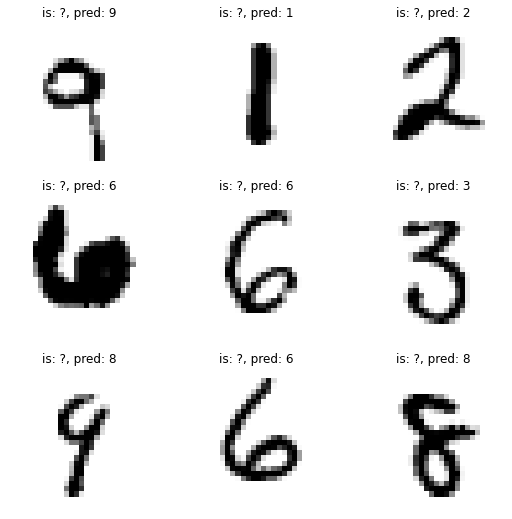

In [ ]:
re_testX = pd.DataFrame(testX).add_prefix('pixel_') # re-engineer x values
re_testX = (re_testX * 255).astype(np.uint8)
guess_plotter = pd.concat([testguess, re_testX], axis = 1)
guess_plotter.shape #(575, 786)
fig, ax = plt.subplots(3, 3, figsize = (9,9)) # lets make a figure
for i in range(1, 10): # 9 pieces - matplotlib wants #1-9, not 0-8
  ax = plt.subplot(3, 3, i) # set subplot
  pick = guess_plotter.sample(1, random_state = i *9) # pick a row
  label = int(pick['label']) # label = for our row
  img = pick.drop(['label', 'imageID'], axis = 1) # pixel values
  img = np.array(img) #convert pixels to array
  img = np.reshape(img, (28,28)) # reshape ot 28x28
  plt.imshow(img, cmap='gray_r') # show image - invert so pen is black
  ax.set_title(f'is: ?, pred: {label}') # title is label and guess
  plt.axis('off')

Looks pretty good to me (except for bottom right...)